In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import imageio.v2 as imageio

%matplotlib inline

# Directorios de trabajo (se crean si no existen)
DATA_DIR = Path("data")
GIF_DIR = Path("gifs")

DATA_DIR.mkdir(exist_ok=True)
GIF_DIR.mkdir(exist_ok=True)

print("Carpeta de datos:", DATA_DIR.resolve())
print("Carpeta de GIFs:", GIF_DIR.resolve())


Carpeta de datos: /content/data
Carpeta de GIFs: /content/gifs


## 1. Carga y visualización de la imagen

En esta sección cargo una imagen a color (RGB) de un animal en vía de extinción y la muestro.


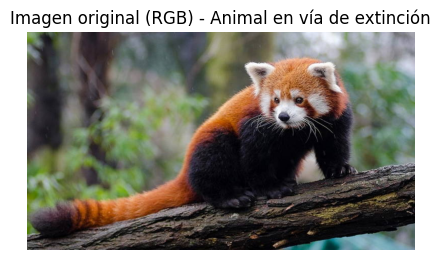

In [ ]:
img_path = DATA_DIR / "data\oso_rojo.jpg"

# Cargar imagen en BGR (formato por defecto de OpenCV)
img_bgr = cv2.imread(str(img_path))

if img_bgr is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {img_path}")

# Convertir a RGB para visualizar correctamente con matplotlib
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Imagen original (RGB) - Animal en vía de extinción")
plt.show()


## 2. Filtros básicos

Se aplica:
- Un filtro de suavizado (desenfoque gaussiano).
- Un filtro de realce de bordes (Laplaciano sobre escala de grises).

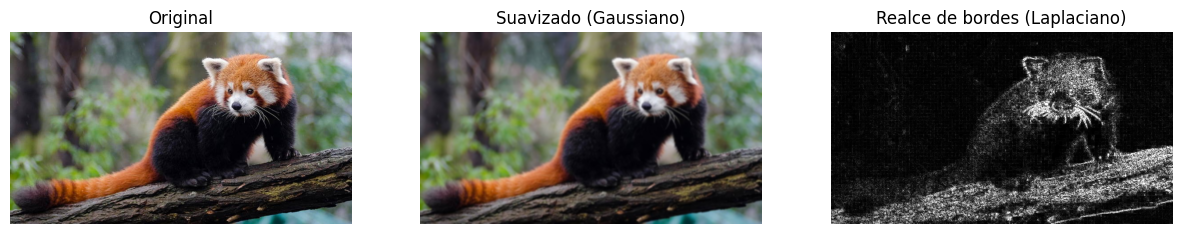

In [11]:
# Filtro de suavizado: desenfoque gaussiano
blur = cv2.GaussianBlur(img_rgb, (7, 7), sigmaX=1.5)

# Escala de grises para el filtro de bordes
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Realce de bordes con Laplaciano
edges_lap = cv2.Laplacian(gray, ddepth=cv2.CV_64F, ksize=3)
edges_lap = cv2.convertScaleAbs(edges_lap)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_rgb)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(blur)
axes[1].set_title("Suavizado (Gaussiano)")
axes[1].axis("off")

axes[2].imshow(edges_lap, cmap="gray")
axes[2].set_title("Realce de bordes (Laplaciano)")
axes[2].axis("off")

plt.show()


**Comentario visual:**

- El **suavizado gaussiano** reduce el ruido y la textura fina, por lo que la imagen se ve más “suave” y menos nítida.
- El **Laplaciano** resalta los cambios bruscos de intensidad: bordes del animal, contornos y límites con el fondo se ven como líneas claras sobre fondo más oscuro.


## 3. Visualización de canales de color (R, G, B)

Se separa la imagen en sus tres canales y se muestra cada uno en escala de grises.


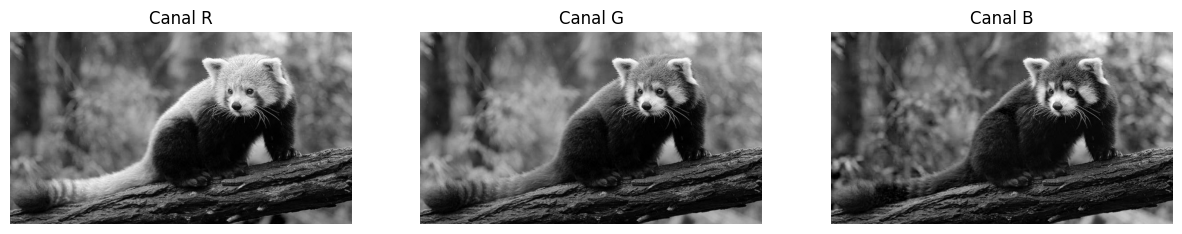

In [12]:
# Separar los tres canales
R = img_rgb[:, :, 0]
G = img_rgb[:, :, 1]
B = img_rgb[:, :, 2]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(R, cmap="gray")
axes[0].set_title("Canal R")
axes[0].axis("off")

axes[1].imshow(G, cmap="gray")
axes[1].set_title("Canal G")
axes[1].axis("off")

axes[2].imshow(B, cmap="gray")
axes[2].set_title("Canal B")
axes[2].axis("off")

plt.show()


**Observaciones por canal:**

- En el canal **R (rojo)** se ven más claras las zonas donde predomina este color (por ejemplo, partes del cuerpo del animal o fondo con tonos cálidos).
- En el canal **G (verde)** se resaltan las áreas con vegetación o tonos verdosos: hojas, plantas, algas, etc.
- En el canal **B (azul)** suelen verse más claras zonas de cielo o agua (si la imagen es marina) o elementos con tonos fríos.

Un valor más claro indica que en esa región hay **más cantidad de ese color**; más oscuro, menos.


## 4. Operaciones morfológicas

Se trabaja sobre una versión binarizada de la imagen y se aplican dos operaciones morfológicas:
- Apertura (opening).
- Cierre (closing).


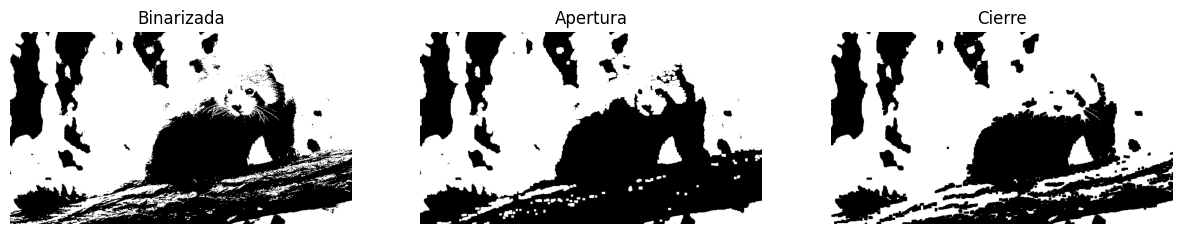

In [13]:
# Binarización con umbral de Otsu sobre la imagen en grises
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Elemento estructurante (kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# Operación 1: Apertura (elimina ruido blanco pequeño)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# Operación 2: Cierre (rellena huecos negros dentro de objetos blancos)
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(binary, cmap="gray")
axes[0].set_title("Binarizada")
axes[0].axis("off")

axes[1].imshow(opening, cmap="gray")
axes[1].set_title("Apertura")
axes[1].axis("off")

axes[2].imshow(closing, cmap="gray")
axes[2].set_title("Cierre")
axes[2].axis("off")

plt.show()


**Efectos de las operaciones morfológicas:**

- La **apertura** (erosión seguida de dilatación) elimina objetos blancos pequeños y ruido aislado, haciendo que las regiones principales queden más “limpias”.
- El **cierre** (dilatación seguida de erosión) tiende a **cerrar huecos negros** dentro de regiones blancas y unir partes cercanas, haciendo los objetos más compactos.


## 5. Animación (GIF)

Se genera un GIF que muestra de forma secuencial:
- Imagen original.
- Filtro suavizado.
- Realce de bordes.
- Imagen binarizada.
- Resultados de apertura y cierre.


In [14]:
frames = []

# Asegurarse de que todos los frames sean RGB
frame_original = img_rgb.copy()
frame_blur = blur.copy()
frame_edges = cv2.cvtColor(edges_lap, cv2.COLOR_GRAY2RGB)
frame_binary = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
frame_opening = cv2.cvtColor(opening, cv2.COLOR_GRAY2RGB)
frame_closing = cv2.cvtColor(closing, cv2.COLOR_GRAY2RGB)

frames.extend([
    frame_original,
    frame_blur,
    frame_edges,
    frame_binary,
    frame_opening,
    frame_closing,
])

gif_path = GIF_DIR / "procesamiento_animal.gif"

# loop=0 → se repite para siempre
imageio.mimsave(
    gif_path,
    frames,
    duration=0.8,  # 0.8 s por frame
    loop=0
)

print("GIF guardado en:", gif_path)


GIF guardado en: gifs/procesamiento_animal.gif
